In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('Training_set_food.csv')

In [3]:
df.head()

,filename,label
0,Image_1.jpg,burgers
1,Image_2.jpg,burgers
2,Image_3.jpg,burgers
3,Image_4.jpg,burgers
4,Image_5.jpg,burgers


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  5400 non-null   object
 1   label     5400 non-null   object
dtypes: object(2)
memory usage: 84.5+ KB


In [5]:
df.label.value_counts()

Pizza         1800
Softdrinks    1800
burgers       1800
Name: label, dtype: int64

In [6]:
arr = df.label.to_numpy()
classes = np.unique(arr)
num_classes = classes.size
num_classes

3

 Dataset is balanced

## Prepare data for data generation

In [2]:
import os
from shutil import copyfile

In [8]:
if not os.path.exists("Dataset"):
    os.mkdir("Dataset")
    os.mkdir("Dataset/Train")
    os.mkdir("Dataset/Train/burgers")
    os.mkdir("Dataset/Train/Pizza")
    os.mkdir("Dataset/Train/Softdrinks")
    os.mkdir("Dataset/Test")
    os.mkdir("Dataset/Test/burgers")
    os.mkdir("Dataset/Test/Pizza")
    os.mkdir("Dataset/Test/Softdrinks")

In [9]:
filename = []
label = []

for i in df.index:
    filename.append(df.filename[i])
    label.append(df.label[i])

In [10]:
b_cnt = 0
p_cnt = 0
s_cnt = 0

In [11]:
for i in range(len(filename)):
    if label[i] == 'burgers':
        if b_cnt <= 1600:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Train',label[i],filename[i]))
            b_cnt+=1
        else:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Test',label[i],filename[i]))
            b_cnt+=1
    elif label[i] == 'Pizza':
        if p_cnt <= 1600:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Train',label[i],filename[i]))
            p_cnt+=1
        else:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Test',label[i],filename[i]))
            b_cnt+=1
    elif label[i] == 'Softdrinks':
        if s_cnt <= 1600:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Train',label[i],filename[i]))
            s_cnt+=1
        else:
            copyfile(os.path.join('train',filename[i]), os.path.join('Dataset','Test',label[i],filename[i]))
            s_cnt+=1

## Image Generator

In [3]:
HEIGHT = 331
WIDTH = 331

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

In [48]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255)

In [49]:
train_dir = 'Dataset/Train'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   target_size = (HEIGHT,WIDTH))  

Found 4803 images belonging to 3 classes.


In [50]:
validation_dir = 'Dataset/Test'
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   target_size = (HEIGHT,WIDTH))

Found 597 images belonging to 3 classes.


## Custom Model

In [45]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

In [185]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(HEIGHT, WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(HEIGHT, WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [188]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 329, 329, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 164, 164, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 162, 162, 64)      9280      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 81, 81, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 79, 79, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 39, 39, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 37, 128)      

In [189]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit(train_generator, 
                             validation_data = validation_generator,
                             epochs=50,
                             verbose=1)

Epoch 1/50
151/151 [==============================] - 158s 1s/step - loss: 1.0937 - accuracy: 0.3518 - val_loss: 0.9534 - val_accuracy: 0.5343
Epoch 2/50
151/151 [==============================] - 103s 683ms/step - loss: 0.9493 - accuracy: 0.5141 - val_loss: 0.8524 - val_accuracy: 0.5729
Epoch 3/50
151/151 [==============================] - 104s 684ms/step - loss: 0.8795 - accuracy: 0.5456 - val_loss: 0.7887 - val_accuracy: 0.6365
Epoch 4/50
151/151 [==============================] - 103s 684ms/step - loss: 0.8403 - accuracy: 0.5564 - val_loss: 0.7688 - val_accuracy: 0.6667
Epoch 5/50
151/151 [==============================] - 103s 683ms/step - loss: 0.7937 - accuracy: 0.6025 - val_loss: 0.7460 - val_accuracy: 0.6750
Epoch 6/50
151/151 [==============================] - 103s 683ms/step - loss: 0.7522 - accuracy: 0.6498 - val_loss: 0.6750 - val_accuracy: 0.7018
Epoch 7/50
151/151 [==============================] - 103s 684ms/step - loss: 0.6955 - accuracy: 0.7020 - val_loss: 0.6137 - va

In [190]:
model.save('custom_model_2.h5')

## Resnet Model

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model

In [15]:
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [16]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
# print(x.shape)
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(8, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x) 

finetune_model = Model(inputs=base_model.input, outputs=predictions)


In [17]:
finetune_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 337, 337, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 166, 166, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 166, 166, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:

finetune_model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

history = finetune_model.fit(train_generator, 
                             validation_data = validation_generator,
                             epochs=36,
                             verbose=1)

Epoch 1/100
151/151 [==============================] - 125s 804ms/step - loss: 4.1982 - accuracy: 0.3587 - val_loss: 1.0707 - val_accuracy: 0.4472
Epoch 2/100
151/151 [==============================] - 122s 806ms/step - loss: 1.0168 - accuracy: 0.4933 - val_loss: 0.9152 - val_accuracy: 0.5645
Epoch 3/100
151/151 [==============================] - 122s 804ms/step - loss: 0.9164 - accuracy: 0.5871 - val_loss: 0.9308 - val_accuracy: 0.6181
Epoch 4/100
151/151 [==============================] - 122s 805ms/step - loss: 0.8792 - accuracy: 0.6055 - val_loss: 0.8075 - val_accuracy: 0.6482
Epoch 5/100
151/151 [==============================] - 122s 807ms/step - loss: 0.8325 - accuracy: 0.6257 - val_loss: 0.8764 - val_accuracy: 0.6064
Epoch 6/100
151/151 [==============================] - 122s 808ms/step - loss: 0.8154 - accuracy: 0.6443 - val_loss: 0.7247 - val_accuracy: 0.6817
Epoch 7/100
151/151 [==============================] - 122s 802ms/step - loss: 0.7935 - accuracy: 0.6565 - val_loss: 0

KeyboardInterrupt: 

In [19]:
finetune_model.save('resnet50_70.h5')

## Rasnet50 

In [12]:
for layer in base_model.layers:
    layer.trainable = False

output = base_model.layers[-1].output
output = tf.keras.layers.Flatten()(output)

resnet_model = Model(inputs=base_model.input, outputs=output)

# x = base_model.output
# # # print(x.shape)
# x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
# x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# # x = tf.keras.layers.Dense(8, activation='relu')(x)
# predictions = tf.keras.layers.Dense(3, activation='softmax')(x) 



In [13]:
model = Sequential()
model.add(resnet_model)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [14]:

model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

history = model.fit(train_generator, 
                             validation_data = validation_generator,
                             epochs=15,
                             verbose=1)

Epoch 1/15
151/151 [==============================] - 127s 808ms/step - loss: 21.3558 - accuracy: 0.3428 - val_loss: 1.0817 - val_accuracy: 0.4322
Epoch 2/15
151/151 [==============================] - 122s 802ms/step - loss: 1.2504 - accuracy: 0.3366 - val_loss: 2.2263 - val_accuracy: 0.3350
Epoch 3/15
151/151 [==============================] - 123s 814ms/step - loss: 1.2317 - accuracy: 0.3315 - val_loss: 2.2397 - val_accuracy: 0.3333
Epoch 4/15
125/151 [=======================>......] - ETA: 18s - loss: 1.4187 - accuracy: 0.3286

KeyboardInterrupt: 

## NASNet

In [8]:
from tensorflow.keras.applications.nasnet import NASNetLarge

In [9]:
base_output_nasnet = NASNetLarge(include_top=False,
                                 weights = 'imagenet',
                                input_shape = (HEIGHT, WIDTH, 3))

In [32]:
for layer in base_model.layers:
    layer.trainable = False

base_layer = base_output_nasnet.get('')
    
x = base_output_nasnet.output
# x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x) 

finetune_model = Model(inputs=base_output_nasnet.input, outputs=predictions)

In [33]:
finetune_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_260 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 11, 11, 672)  2688        separable_conv_2_normal_right1_18
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 11, 11, 672)  2688        separable_conv_2_normal_left2_18[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 11, 11, 672)  2688        separable_conv_2_normal_right2_18
__________________________________________________________________________________________________
normal_left3_18 (AveragePooling (None, 11, 11, 672)  0           normal_bn_1_18[0][0]             
__________________________________________________________________________________________________
normal_left4_18 (AveragePooling (None, 11, 11, 672)  0           adjust_bn_18[0][0]               
__________

In [43]:
finetune_model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

history = finetune_model.fit(train_generator, 
                             validation_data = validation_generator,
                             epochs=10,
                             verbose=1)

Epoch 1/10
 740/2402 [========>.....................] - ETA: 32:39 - loss: 1.8203 - accuracy: 0.3378

KeyboardInterrupt: 

## Start Training

In [33]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')- logs.get('val_acc') > 0.05):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [49]:
finetune_model.save('resnet50_66.h5')

## Accuracy

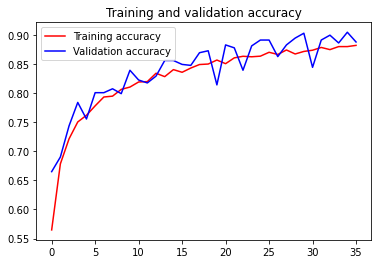

<Figure size 432x288 with 0 Axes>

In [104]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Prediction

In [158]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

In [171]:
model1 = tf.keras.models.load_model('custom_model.h5')

In [167]:
model2 = tf.keras.models.load_model('resnet50_70.h5')

In [191]:
model3 = tf.keras.models.load_model('custom_model_2.h5')

In [172]:
def get_image(path, model):
    img = image.load_img(path, target_size=(HEIGHT, WIDTH, 3))
    x = image.img_to_array(img)
#     print(x.shape)
    x = np.expand_dims(x, axis = 0)
#     print(x.shape)
    classes = model.predict(x, batch_size = 0)
    return classes

In [173]:
test_df = pd.read_csv('Testing_set_food.csv')

test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [198]:
predicted_classes = []

for i in tqdm(test_df.index):
#     print(test_df.filename[i])
    value = tf.argmax(get_image(os.path.join('test',test_df.filename[i]), model3), axis = 1)
#     value = tf.argmax(get_image(os.path.join('test/Image_109.jpg')), axis = 1)
#     print(get_image(os.path.join('test/Image_101.jpg')))
    if value[0] == 0:
        predicted_classes.append("pizza")
    elif value[0] == 1:
        predicted_classes.append("softdrinks")
    else:
        predicted_classes.append("burgers")
    

100%|██████████| 1800/1800 [01:03<00:00, 28.13it/s]


In [199]:
res = pd.DataFrame(predicted_classes)
res.head()

,0
0,softdrinks
1,softdrinks
2,softdrinks
3,burgers
4,softdrinks


In [200]:
res.columns = ["prediction"]
res.to_csv("prediction_results.csv", index = False)